In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization
from keras.losses import binary_crossentropy, mse
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc

In [2]:
dfm = pd.read_csv('/Users/wangziwen/Documents/Graduation/1st/Statistic Learning/project/marketdata_sample.csv')
dfn = pd.read_csv('/Users/wangziwen/Documents/Graduation/1st/Statistic Learning/project/news_sample.csv')

## Only Market

In [48]:
cat_cols = ['assetCode']
num_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
                    'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
                    'returnsOpenPrevMktres10']

In [49]:
train_indices, val_indices = train_test_split(dfm.index.values,test_size=0.25, random_state=23)

In [50]:
def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

encoders = [{} for cat in cat_cols]


for i, cat in enumerate(cat_cols):
    print('encoding %s ...' % cat, end=' ')
    encoders[i] = {l: id for id, l in enumerate(dfm.loc[train_indices, cat].astype(str).unique())}
    dfm[cat] = dfm[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    print('Done')

embed_sizes = [len(encoder) + 1 for encoder in encoders] #+1 for possible unknown assets

encoding assetCode ... Done


In [51]:
dfm[num_cols] = dfm[num_cols].fillna(0)
print('scaling numerical columns')

scaler = StandardScaler()

#col_mean = market_train[col].mean()
#market_train[col].fillna(col_mean, inplace=True)
scaler = StandardScaler()
dfm[num_cols] = scaler.fit_transform(dfm[num_cols])

scaling numerical columns


In [8]:
#FCNN
categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='relu')(categorical_logits)

numerical_inputs = Input(shape=(11,), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dense(64,activation='relu')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='relu')(logits)
out = Dense(1, activation='sigmoid')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
model.compile(optimizer='adam',loss=binary_crossentropy)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                [(None, 11)]         0                                            
__________________________________________________________________________________________________
assetCode (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 11)           44          num[0][0]                        
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        760         assetCode[0][0]                  
______________________________________________________________________________________________

In [52]:
def get_input(dfm, indices):
    X_num = dfm.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = dfm.loc[indices, cat_cols].values
    y = (dfm.loc[indices,'returnsOpenNextMktres10'] >= 0).values #為什麼要>=0? 因為分類
    r = dfm.loc[indices,'returnsOpenNextMktres10'].values
    u = dfm.loc[indices, 'universe']
    d = pd.to_datetime(dfm.loc[indices, 'time']).dt.date
    return X,y,r,u,d

In [53]:
# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(dfm, train_indices)
X_valid,y_valid,r_valid,u_valid,d_valid = get_input(dfm, val_indices)

In [54]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train['num'], y_train)

In [62]:
confidence_valid = clf.predict(X_valid['num'])
accuracy_score(confidence_valid,y_valid)

0.68

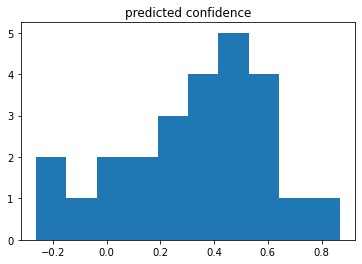

In [78]:
plt.hist(clf.predict_proba(X_valid['num'])[:,1]*2-1)
plt.title("predicted confidence")
plt.show()

In [12]:
check_point = ModelCheckpoint('model.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
model.fit(X_train,y_train.astype(int),
          validation_data=(X_valid,y_valid.astype(int)),
          epochs=2,
          verbose=True,
          callbacks=[early_stop,check_point]) 

Epoch 1/2
3/3 [==============================] - 1s 357ms/step - loss: 0.7027 - val_loss: 0.6811

Epoch 00001: val_loss improved from inf to 0.68108, saving model to model.hdf5
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.6853 - val_loss: 0.6663

Epoch 00002: val_loss improved from 0.68108 to 0.66627, saving model to model.hdf5


0.56


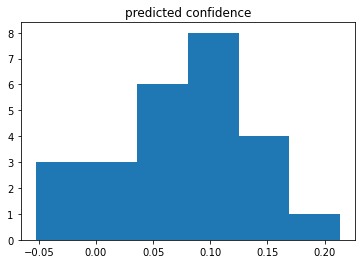

In [13]:
# distribution of confidence that will be used as submission
model.load_weights('model.hdf5')
confidence_valid = model.predict(X_valid)[:,0]*2 -1 #為什麼要*2-1?
print(accuracy_score(confidence_valid>0,y_valid))
plt.hist(confidence_valid, bins='auto')
plt.title("predicted confidence")
plt.show()

In [14]:
accuracy_score(confidence_valid>0,y_valid)

0.56

In [15]:
# 因為sample只有一天才導致std=0因此算不出score
# calculation of actual metric that is used to calculate final score
r_valid = r_valid.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_valid * r_valid * u_valid
data = {'day' : d_valid, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

inf


<ipython-input-15-c6e0e1f5d887>:10: RuntimeWarning: divide by zero encountered in double_scalars
  score_valid = mean / std


## Market+News with 1 category var

In [16]:
dfm = pd.read_csv('/Users/wangziwen/Documents/Graduation/1st/Statistic Learning/project/marketdata_sample.csv')
dfn = pd.read_csv('/Users/wangziwen/Documents/Graduation/1st/Statistic Learning/project/news_sample.csv')

In [3]:
def preprocess_news(news_train):
    drop_list = [
        'audiences', 'subjects',
        'headline', 'firstCreated', 'sourceTimestamp',
    ]
    news_train.drop(drop_list, axis=1, inplace=True)
    
    # Factorize categorical columns
    for col in ['headlineTag', 'provider', 'sourceId']:
        news_train[col], uniques = pd.factorize(news_train[col])
        del uniques
    
    # Remove {} and '' from assetCodes column
    news_train['assetCodes'] = news_train['assetCodes'].apply(lambda x: x[1:-1].replace("'", ""))
    return news_train
news_train = preprocess_news(dfn)

In [4]:
def unstack_asset_codes(news_train):
    codes = []
    indexes = []
    for i, values in news_train['assetCodes'].iteritems():
        explode = values.split(", ")
        codes.extend(explode)
        repeat_index = [int(i)]*len(explode)
        indexes.extend(repeat_index)
    index_df = pd.DataFrame({'news_index': indexes, 'assetCode': codes})
    del codes, indexes
    gc.collect()
    return index_df

#因為要根據asset_code來merge
index_df = unstack_asset_codes(news_train)

In [5]:
def merge_news_on_index(news_train, index_df):
    news_train['news_index'] = news_train.index.copy()

    # Merge news on unstacked assets
    news_unstack = index_df.merge(news_train, how='left', on='news_index')
    news_unstack.drop(['news_index', 'assetCodes'], axis=1, inplace=True)
    return news_unstack

news_unstack = merge_news_on_index(news_train, index_df)
del news_train, index_df
gc.collect()

0

In [6]:
def group_news(news_frame):
    news_frame['date'] = pd.to_datetime(news_frame.time).dt.date  # Add date column
    
    aggregations = ['mean']
    gp = news_frame.groupby(['assetCode', 'date','assetName']).agg(aggregations)
    gp.columns = pd.Index(["{}_{}".format(e[0], e[1]) for e in gp.columns.tolist()])
    gp.reset_index(inplace=True)
    # Set datatype to float32
    float_cols = {c: 'float32' for c in gp.columns if c not in ['assetCode', 'date','assetName']}
    return gp.astype(float_cols)

news_agg1 = group_news(news_unstack)
drop_list = [
        'noveltyCount12H_mean', 'noveltyCount24H_mean', 'noveltyCount3D_mean', 'noveltyCount5D_mean', 
    'noveltyCount7D_mean', 'sentimentClass_mean', 'marketCommentary_mean',
'headlineTag_mean', 'provider_mean', 'takeSequence_mean', 'urgency_mean' 
    ]
news_agg1.drop(drop_list, axis=1, inplace=True)
#del news_unstack; gc.collect()
 #169 group by assetCode and mean

In [7]:
news_agg2 = group_news(news_unstack)
news_agg2 = news_agg2[[ 'assetCode', 'date', 'assetName',
        'noveltyCount12H_mean', 'noveltyCount24H_mean', 'noveltyCount3D_mean', 'noveltyCount5D_mean', 
    'noveltyCount7D_mean', 'sentimentClass_mean', 'marketCommentary_mean', 'provider_mean', 'takeSequence_mean'
    ]]
#del news_unstack; gc.collect()
news_agg2 = news_agg2.round() #169 group by assetCode and mean
cat_col = news_agg2.select_dtypes(include='float32').columns.to_list()
news_agg2[cat_col] = news_agg2[cat_col].astype('int').astype('category')
news_agg = news_agg1.merge(news_agg2, how='left', on=['assetCode', 'date','assetName'])
dfm['date'] = pd.to_datetime(dfm.time).dt.date
df = dfm.merge(news_agg, how='left', on=['assetCode', 'date'])

In [8]:
cat_cols = ['assetCode']
num_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
                    'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
                    'returnsOpenPrevMktres10','bodySize_mean','sentenceCount_mean','wordCount_mean',
           'relevance_mean', 'volumeCounts12H_mean']

In [9]:
train_indices, val_indices = train_test_split(df.index.values,test_size=0.25, random_state=23)

In [10]:
def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

encoders = [{} for cat in cat_cols]


for i, cat in enumerate(cat_cols):
    print('encoding %s ...' % cat, end=' ')
    encoders[i] = {l: id for id, l in enumerate(df.loc[train_indices, cat].astype(str).unique())}
    df[cat] = df[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    print('Done')

embed_sizes = [len(encoder) + 1 for encoder in encoders] #+1 for possible unknown assets

encoding assetCode ... Done


In [25]:
df[num_cols] = df[num_cols].fillna(0)
print('scaling numerical columns')

scaler = StandardScaler()

#col_mean = market_train[col].mean()
#market_train[col].fillna(col_mean, inplace=True)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

scaling numerical columns


In [26]:
categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))

#categorical_embeddings = []
#for i, cat in enumerate(cat_cols):
#    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='relu')(categorical_logits)

#numerical_inputs = Input(shape=(11,), name='num')
numerical_inputs = Input(shape=(16,), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dense(64,activation='relu')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='relu')(logits)
out = Dense(1, activation='sigmoid')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
model.compile(optimizer='adam',loss=binary_crossentropy)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                [(None, 16)]         0                                            
__________________________________________________________________________________________________
assetCode (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16)           64          num[0][0]                        
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        760         assetCode[0][0]                  
____________________________________________________________________________________________

In [28]:
def get_input(df, indices):
    X_num = df.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = df.loc[indices, cat_cols].values
    y = (df.loc[indices,'returnsOpenNextMktres10'] >= 0).values #為什麼要>=0? 因為分類
    r = df.loc[indices,'returnsOpenNextMktres10'].values
    u = df.loc[indices, 'universe']
    d = pd.to_datetime(df.loc[indices, 'time']).dt.date
    return X,y,r,u,d

In [29]:
# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(df, train_indices)
X_valid,y_valid,r_valid,u_valid,d_valid = get_input(df, val_indices)

In [30]:
check_point = ModelCheckpoint('model.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
model.fit(X_train,y_train.astype(int),
          validation_data=(X_valid,y_valid.astype(int)),
          epochs=2,
          verbose=True,
          callbacks=[early_stop,check_point]) 

Epoch 1/2
3/3 [==============================] - 1s 80ms/step - loss: 0.6825 - val_loss: 0.6810

Epoch 00001: val_loss improved from inf to 0.68101, saving model to model.hdf5
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.6500 - val_loss: 0.6770

Epoch 00002: val_loss improved from 0.68101 to 0.67704, saving model to model.hdf5


0.64


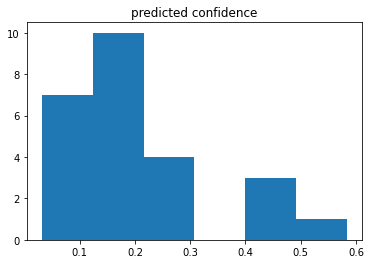

In [31]:
# distribution of confidence that will be used as submission
model.load_weights('model.hdf5')
confidence_valid = model.predict(X_valid)[:,0]*2 -1 #為什麼要*2-1?
print(accuracy_score(confidence_valid>0,y_valid))
plt.hist(confidence_valid, bins='auto')
plt.title("predicted confidence")
plt.show()

In [32]:
accuracy_score(confidence_valid>0,y_valid)

0.64

In [ ]:
# 因為sample只有一天才導致std=0因此算不出score
# calculation of actual metric that is used to calculate final score
r_valid = r_valid.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_valid * r_valid * u_valid
data = {'day' : d_valid, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

## Market+News with 1 category var

In [33]:
cat_cols = ['assetCode', 'noveltyCount12H_mean', 'sentimentClass_mean', 'marketCommentary_mean', 'takeSequence_mean', ]
num_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
                    'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
                    'returnsOpenPrevMktres10','bodySize_mean','sentenceCount_mean','wordCount_mean',
           'relevance_mean', 'volumeCounts12H_mean']

In [34]:
train_indices, val_indices = train_test_split(df.index.values,test_size=0.25, random_state=23)

In [37]:
def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

encoders = [{} for cat in cat_cols]


for i, cat in enumerate(cat_cols):
    print('encoding %s ...' % cat, end=' ')
    encoders[i] = {l: id for id, l in enumerate(df.loc[train_indices, cat].astype(str).unique())}
    df[cat] = df[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    print('Done')

embed_sizes = [len(encoder) + 1 for encoder in encoders] #+1 for possible unknown assets

encoding assetCode ... Done
encoding noveltyCount12H_mean ... Done
encoding sentimentClass_mean ... Done
encoding marketCommentary_mean ... Done
encoding takeSequence_mean ... Done


In [38]:
df[num_cols] = df[num_cols].fillna(0)
print('scaling numerical columns')

scaler = StandardScaler()

#col_mean = market_train[col].mean()
#market_train[col].fillna(col_mean, inplace=True)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

scaling numerical columns


In [39]:
categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[5], name=cat))

#categorical_embeddings = []
#for i, cat in enumerate(cat_cols):
#    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='relu')(categorical_logits)

#numerical_inputs = Input(shape=(11,), name='num')
numerical_inputs = Input(shape=(16,), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dense(64,activation='relu')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='relu')(logits)
out = Dense(1, activation='sigmoid')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
model.compile(optimizer='adam',loss=binary_crossentropy)

In [40]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                [(None, 16)]         0                                            
__________________________________________________________________________________________________
assetCode (InputLayer)          [(None, 5)]          0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 16)           64          num[0][0]                        
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5, 10)        760         assetCode[0][0]                  
____________________________________________________________________________________________

In [41]:
def get_input(df, indices):
    X_num = df.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = df.loc[indices, cat_cols].values
    y = (df.loc[indices,'returnsOpenNextMktres10'] >= 0).values #為什麼要>=0? 因為分類
    r = df.loc[indices,'returnsOpenNextMktres10'].values
    u = df.loc[indices, 'universe']
    d = pd.to_datetime(df.loc[indices, 'time']).dt.date
    return X,y,r,u,d

In [42]:
# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(df, train_indices)
X_valid,y_valid,r_valid,u_valid,d_valid = get_input(df, val_indices)

In [43]:
check_point = ModelCheckpoint('model.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
model.fit(X_train,y_train.astype(int),
          validation_data=(X_valid,y_valid.astype(int)),
          epochs=2,
          verbose=True,
          callbacks=[early_stop,check_point]) 

Epoch 1/2
3/3 [==============================] - 1s 94ms/step - loss: 0.6682 - val_loss: 0.6581

Epoch 00001: val_loss improved from inf to 0.65808, saving model to model.hdf5
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.6452 - val_loss: 0.6531

Epoch 00002: val_loss improved from 0.65808 to 0.65314, saving model to model.hdf5


0.64


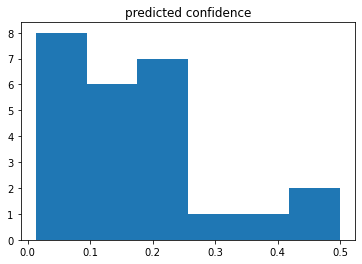

In [44]:
# distribution of confidence that will be used as submission
model.load_weights('model.hdf5')
confidence_valid = model.predict(X_valid)[:,0]*2 -1 #為什麼要*2-1?
print(accuracy_score(confidence_valid>0,y_valid))
plt.hist(confidence_valid, bins='auto')
plt.title("predicted confidence")
plt.show()

In [45]:
accuracy_score(confidence_valid>0,y_valid)

0.64

In [ ]:
# 因為sample只有一天才導致std=0因此算不出score
# calculation of actual metric that is used to calculate final score
r_valid = r_valid.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_valid * r_valid * u_valid
data = {'day' : d_valid, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

## Corr plot

In [14]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

### only market

<ipython-input-48-2c9745b4f217>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


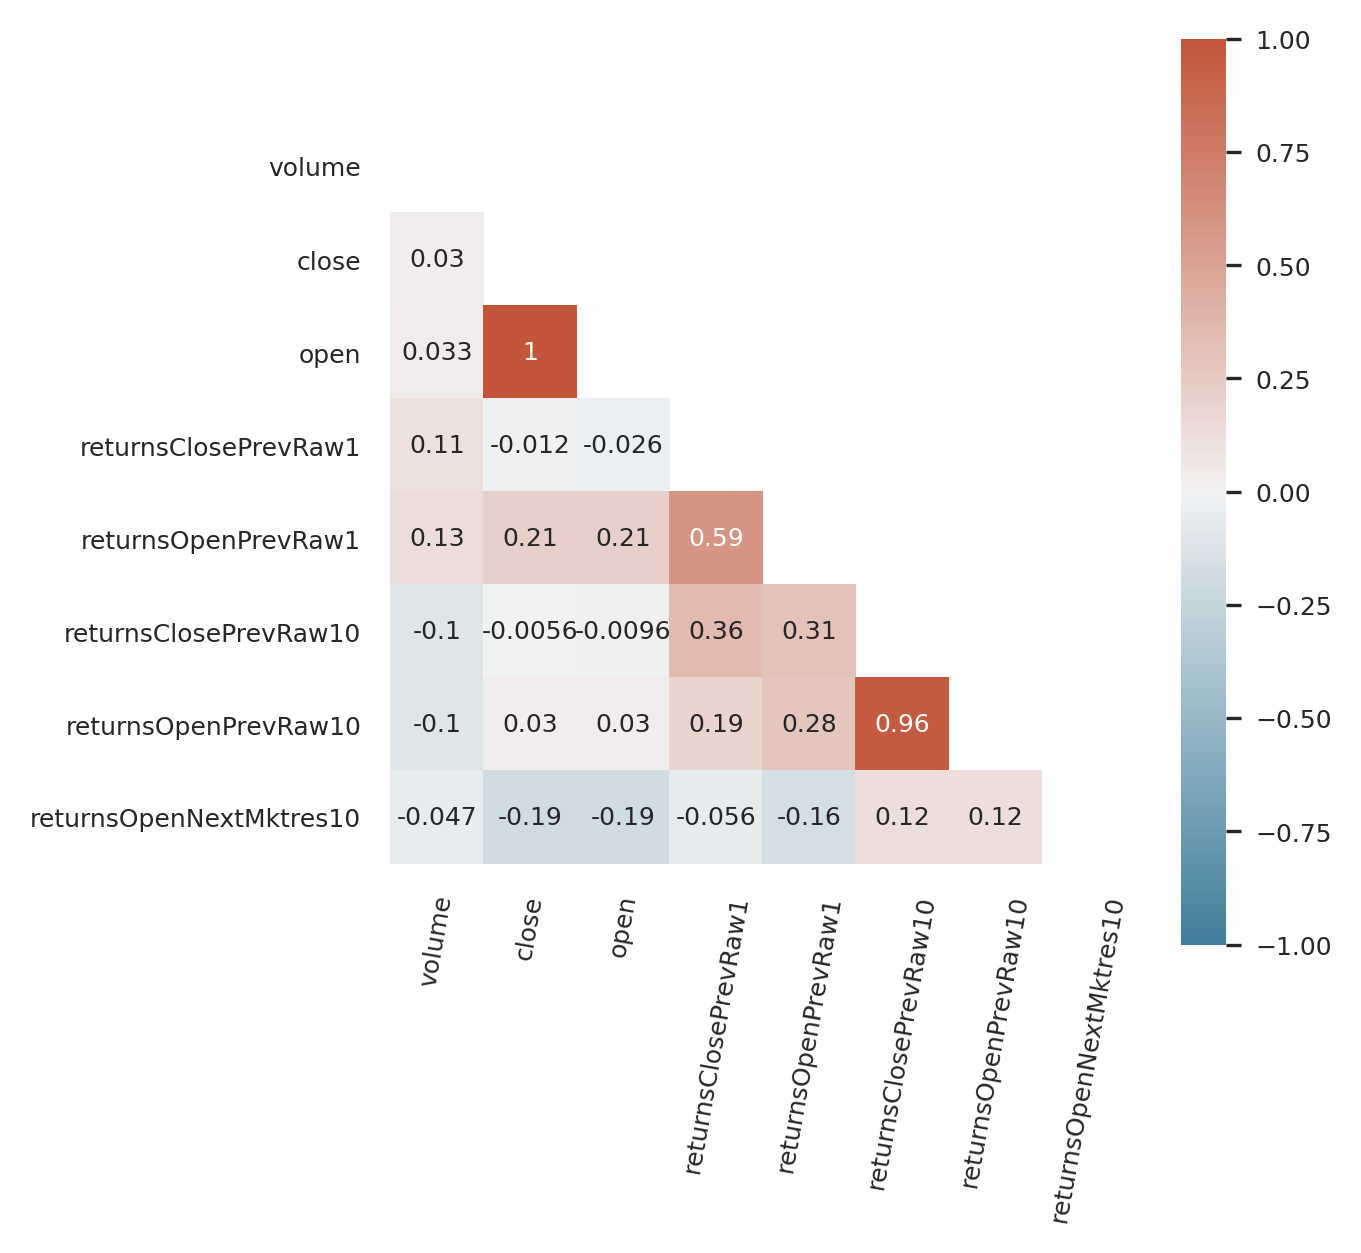

In [48]:
#corr 
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr_num = ['volume','close','open','returnsClosePrevRaw1',
            'returnsOpenPrevRaw1','returnsClosePrevMktres1','returnsOpenPrevMktres1',  
            'returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10',
            'returnsOpenPrevMktres10','returnsOpenNextMktres10']
corr = dfm[corr_num].dropna(axis='columns').corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(4, 4))
    ax = sns.heatmap(corr,square=True, annot=True, cmap=cmap,vmin=-1,vmax=1, annot_kws={"size": 6},mask=mask)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 6, rotation=80)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=6)
plt.show()

### market+news

<ipython-input-53-e37707b6c1b2>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


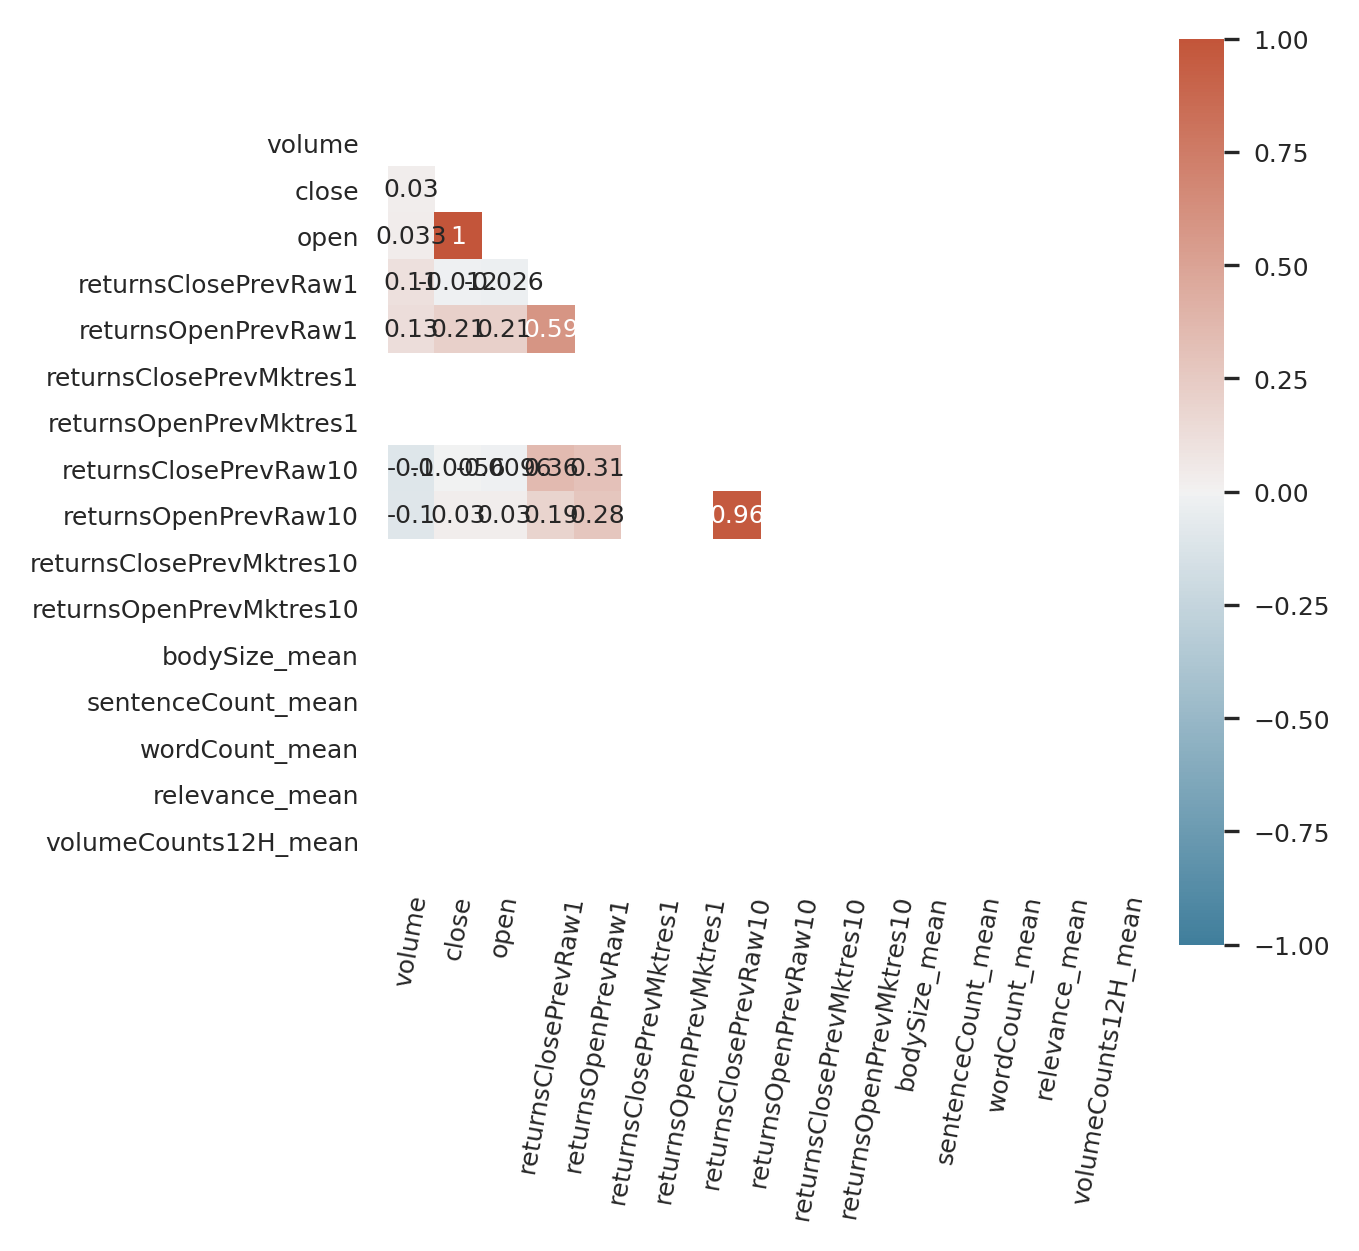

In [53]:
#corr 
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr_num = ['volume','close','open','returnsClosePrevRaw1','returnsOpenPrevRaw1',
            'returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevRaw10',
            'returnsOpenPrevRaw10','returnsClosePrevMktres10','returnsOpenPrevMktres10',
            'returnsOpenNextMktres10','bodySize_mean','sentenceCount_mean','wordCount_mean',
            'relevance_mean','volumeCounts12H_mean']
df[corr_num] = df[corr_num].fillna(0)
corr = df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(4, 4))
    ax = sns.heatmap(corr,square=True, annot=True, cmap=cmap,vmin=-1,vmax=1, annot_kws={"size": 6},mask=mask)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 6, rotation=80)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=6)
plt.show()

### only market

In [71]:
y = pd.DataFrame({'col1': dfm['returnsOpenNextMktres10']})
y['target']=(y['col1']>0)*1
y['target'] = y['target'].astype('int').astype('category')

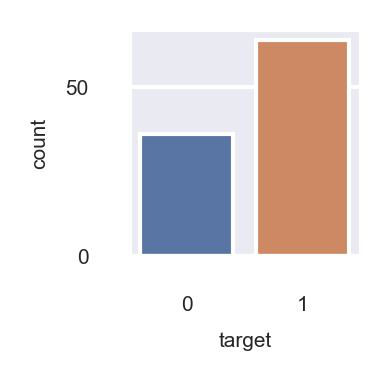

In [74]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(1,1))
sns.countplot(x="target", data=y)
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(5)
plt.xlabel('target', fontsize=5)
plt.ylabel('count', fontsize=5)
plt.show()

### market+news

In [75]:
y = pd.DataFrame({'col1': df['returnsOpenNextMktres10']})
y['target']=(y['col1']>0)*1
y['target'] = y['target'].astype('int').astype('category')

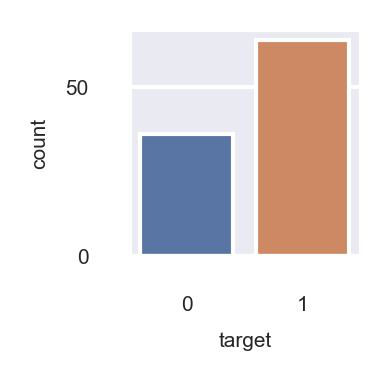

In [76]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(1,1))
sns.countplot(x="target", data=y)
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(5)
plt.xlabel('target', fontsize=5)
plt.ylabel('count', fontsize=5)
plt.show()